In [1]:
%load_ext autoreload
%autoreload 2
import gc
import re
import pandas as pd
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
import os
import sys
HOME = os.path.expanduser("~")
sys.path.append(f'{HOME}/kaggle/data_analysis/library')
import utils
from utils import get_categorical_features, get_numeric_features
import datetime

from tqdm import tqdm
import time
import sys

os.listdir('../input/')
key = 'card_id'
target = 'target'
ignore_list = [key, target, 'merchant_id', 'first_avtive_month']

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

df_train = utils.read_df_pkl('../input/train0*')
df_test = utils.read_df_pkl('../input/test0*')
df_train.set_index(key, inplace=True)
df_test.set_index(key, inplace=True)
df_hist = utils.read_df_pkl('../input/hist*0*')
df_new = utils.read_df_pkl('../input/new*0*')

df_train = reduce_mem_usage(df_train)
df_test  = reduce_mem_usage(df_test )
df_hist  = reduce_mem_usage(df_hist )
df_new   = reduce_mem_usage(df_new  )
train_test = pd.concat([df_train, df_test], axis=0)
df_hist = df_hist.merge(train_test, how='inner', on=key)
df_new = df_new.merge(train_test, how='inner', on=key)

100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)
Mem. usage decreased to 1971.22 Mb (40.8% reduction)
Mem. usage decreased to 140.41 Mb (37.5% reduction)


In [80]:
for df in [df_hist, df_new]:
#     df['category_1'] = df['category_1'].map(lambda x: 0 if x=='N' else 1)
#     df['purchase_amount'] = df['purchase_amount'] - df['purchase_amount'].min() + 1.0e-5
#     df['purchase_date'] = pd.to_datetime(df['purchase_date'])
#     df['first_active_month'] = pd.to_datetime(df['first_active_month'])
#     df['authorized_flag'] = df['authorized_flag'].map(lambda x: 0 if x=='N' else 1)
#     df['all_term'] = (pd.to_datetime('2018-05-01') - df['first_active_month']).dt.days
#     df['yyyymm'] = df['purchase_date'].map(lambda x: str(x)[:7])
#     df['yyyymmdd'] = df['purchase_date'].map(lambda x: str(x)[:11])
#     df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['yyyy_week'] = df['yyyymm'].map(lambda x: str(x)[:4]) + df['weekofyear'].map(lambda x: '-0' + str(x) if len(str(x))==1 else '-' + str(x) )
df_trans = pd.concat([df_hist, df_new], axis=0)
df_hist.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,feature_1,feature_2,feature_3,first_active_month,target,all_term,yyyymm,yyyymmdd,weekofyear,yyyy_week
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,0.043587,2017-06-25 15:33:07,1.0,16,37,3,3,1,2016-06-01,NaN,699.0,2017-06,2017-06-25,25,2017-25
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,0.013789,2017-07-15 12:10:45,1.0,16,16,3,3,1,2016-06-01,NaN,699.0,2017-07,2017-07-15,28,2017-28
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,0.026532,2017-08-09 22:04:29,1.0,16,37,3,3,1,2016-06-01,NaN,699.0,2017-08,2017-08-09,32,2017-32
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,0.011565,2017-09-02 10:06:26,1.0,16,34,3,3,1,2016-06-01,NaN,699.0,2017-09,2017-09-02,35,2017-35
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,0.024052,2017-03-10 01:14:19,1.0,16,37,3,3,1,2016-06-01,NaN,699.0,2017-03,2017-03-10,10,2017-10


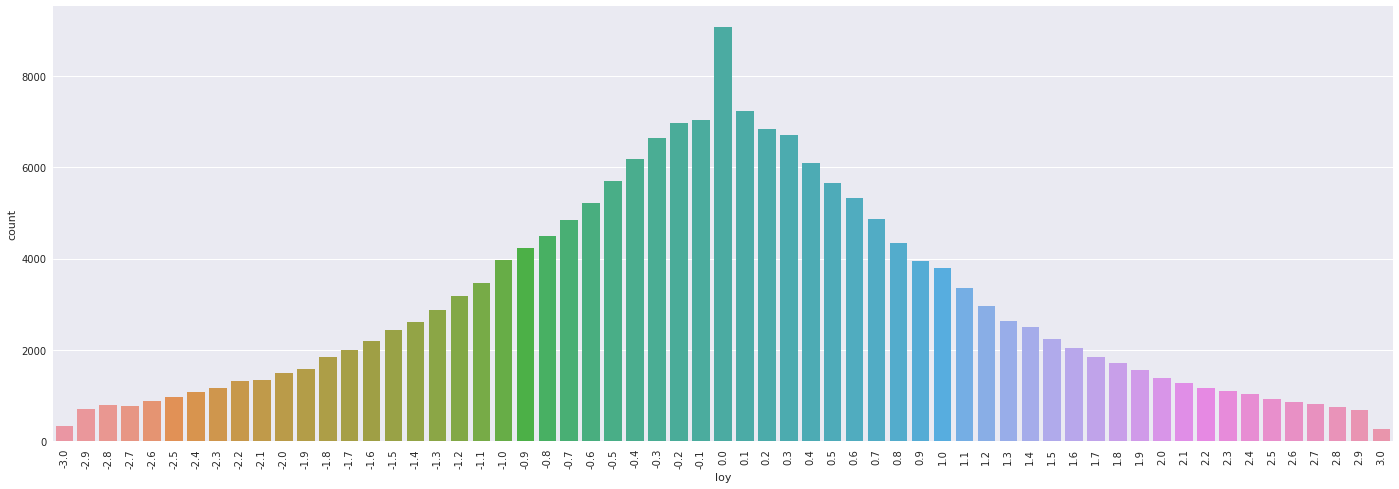

In [85]:
# df_train['loy'] = df_train[target].map(lambda x: np.round(x, 1))
viz = df_train[df_train[target]>-3]
viz = viz[viz[target]<3]
loy_list = viz['loy'].drop_duplicates().sort_values()
plt.figure(figsize=(24, 8))
sns.countplot(data=viz, x='loy', order=loy_list)
plt.xticks(rotation=90)
pass

In [89]:
loy0 = np.array(viz[viz['loy']==0].index)
loy1 = np.array(viz.query("1<=loy and loy<=2").index)
loy1.shape

(25993,)

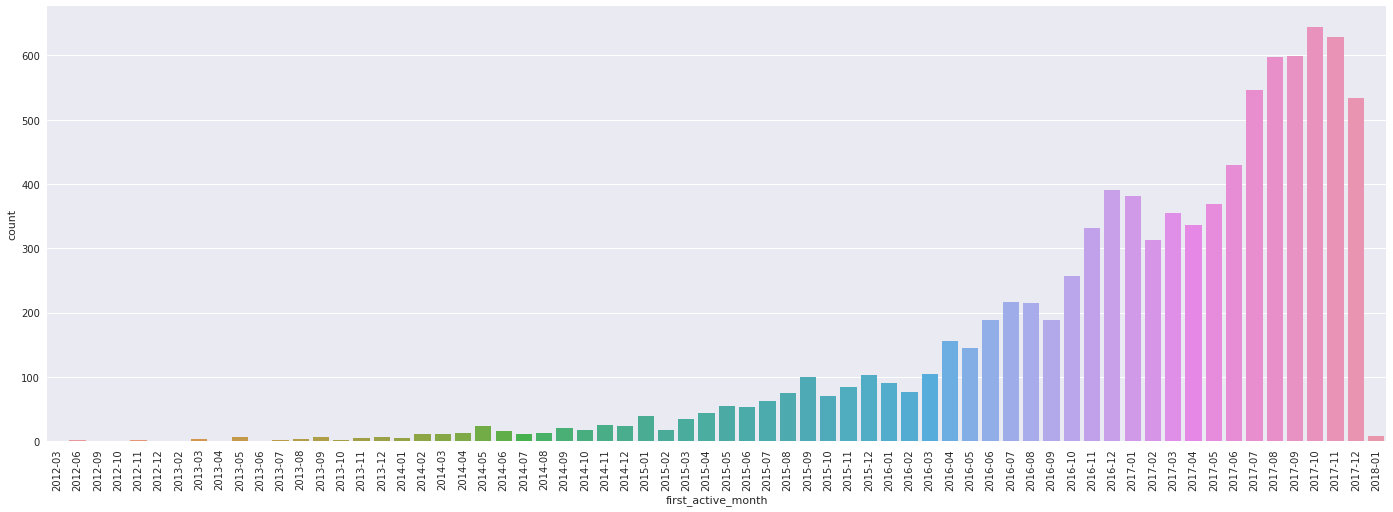

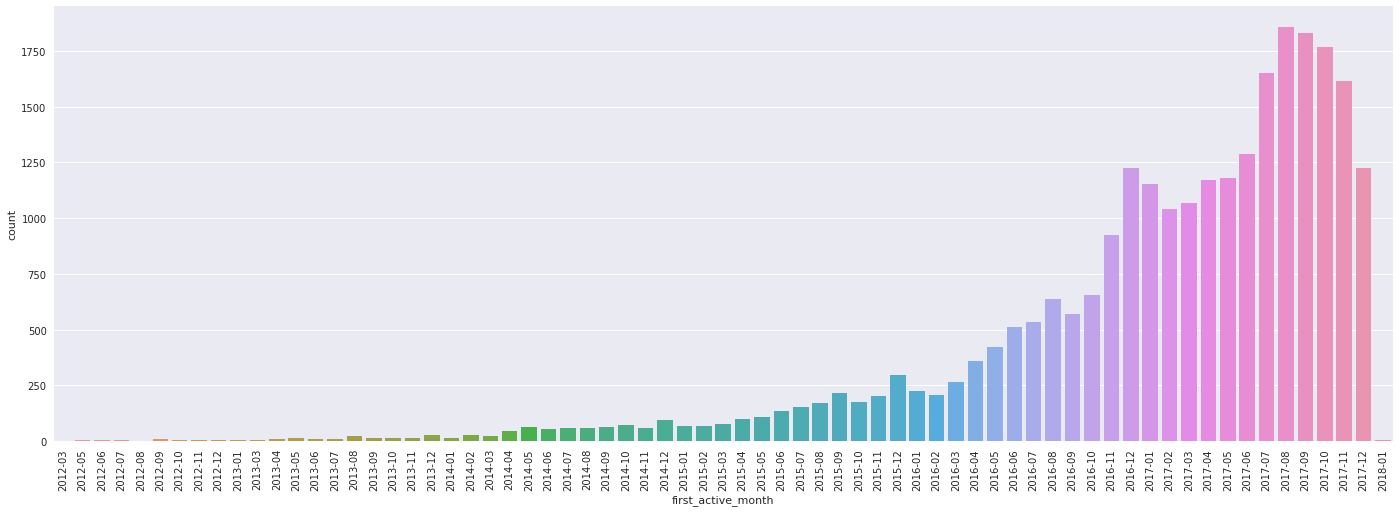

In [93]:
df_loy0 = df_train.loc[loy0, :]
first_months = df_loy0['first_active_month'].drop_duplicates().sort_values()
plt.figure(figsize=(24, 8))
sns.countplot(data=df_loy0, x='first_active_month', order=first_months)
plt.xticks(rotation=90)

df_loy1 = df_train.loc[loy1, :]
first_months = df_loy1['first_active_month'].drop_duplicates().sort_values()
plt.figure(figsize=(24, 8))
sns.countplot(data=df_loy1, x='first_active_month', order=first_months)
plt.xticks(rotation=90)
pass

In [7]:
new_last = df_new[[key, 'yyyymm']].drop_duplicates()
new_last = new_last.groupby(key)['yyyymm'].max().reset_index()

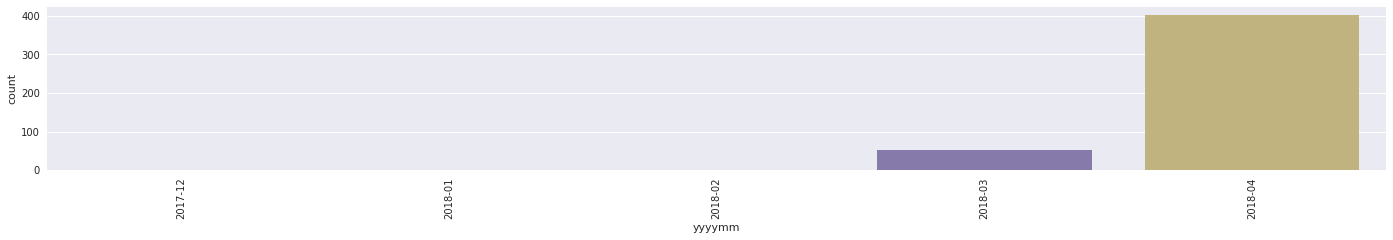

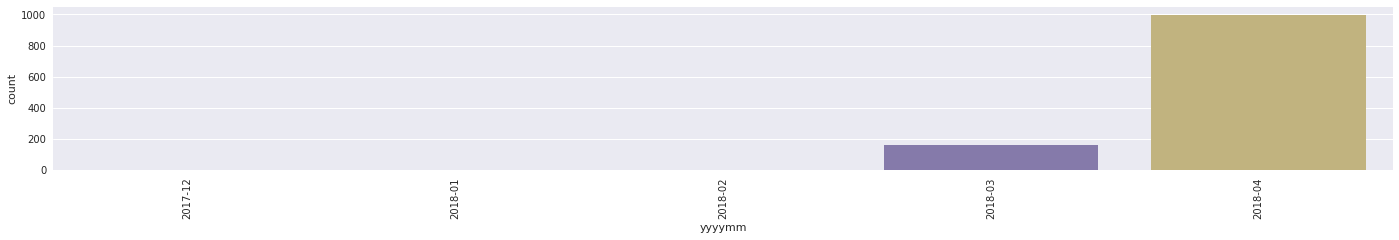

In [162]:
id_loy0 = list(df_loy0[df_loy0['first_active_month']=='2017-12'].index)
viz_loy0 = new_last.loc[new_last.card_id.isin(id_loy0), :]
yyyymm_list = viz['yyyymm'].drop_duplicates().sort_values()

plt.figure(figsize=(24, 3))
sns.countplot(data=viz_loy0, x='yyyymm', order=yyyymm_list)
plt.xticks(rotation=90)
pass

id_loy1 = list(df_loy1[df_loy1['first_active_month']=='2017-12'].index)
viz_loy1 = new_last.loc[new_last.card_id.isin(id_loy1), :]
yyyymm_list = viz['yyyymm'].drop_duplicates().sort_values()

plt.figure(figsize=(24, 3))
sns.countplot(data=viz_loy1, x='yyyymm', order=yyyymm_list)
plt.xticks(rotation=90)
pass

In [163]:
df_hist.loc[df_hist.card_id.isin(id_loy0), :]['yyyymm'].value_counts()

2018-01    7468
2018-02    7196
2017-12    5611
2017-11      35
2017-10      12
2017-04       3
2017-07       3
2017-08       3
2017-09       2
2017-05       1
Name: yyyymm, dtype: int64

In [164]:
id_loy0 = viz_loy0[viz_loy0['yyyymm']=='2018-04'][key].values
eda_loy0 = df_hist.loc[df_hist[key].isin(id_loy0), :]
eda_loy0.shape

id_loy1 = viz_loy1[viz_loy1['yyyymm']=='2018-04'][key].values
eda_loy1 = df_hist.loc[df_hist[key].isin(id_loy1), :]
eda_loy1.shape

(32782, 24)

In [165]:
eda_loy0.shape

(17789, 24)

In [169]:
eda_loy0.groupby(key).size().value_counts().head(10)
# 34     114
# 24     111
# 21     109
# 27     106
# 37     106

23    14
20    12
22    12
29    11
18    11
28    10
12    10
33     9
21     9
15     8
dtype: int64

In [170]:
tmp = eda_loy0.groupby(key).size()
# loy0_15 = list(tmp[tmp==15].index)
loy0_15 = eda_loy0[key].values
tmp = eda_loy1.groupby(key).size()
# loy1_15 = list(tmp[tmp==15].index)
loy1_15 = eda_loy1[key].values
# df_loy0_15 = df_train.loc[loy0_15, :]
# loy.sort_values(by=target)

In [171]:
num_list = get_numeric_features(df=df_hist, ignore_list=ignore_list)
cat_list = get_categorical_features(df=df_hist, ignore_list=[])

trans = df_trans.loc[df_trans[key].isin(loy0_15), :]
trans_sum = trans.groupby([key, 'yyyymm'])[num_list].sum()
trans_nuq = trans.groupby([key, 'yyyymm'])[cat_list].nunique()
trans_sum.columns =  [f"{col}_sum" for col in trans_sum.columns]
trans_nuq.columns =  [f"{col}_nuq" for col in trans_nuq.columns]
trans_agg_loy0 = pd.concat([trans_sum, trans_nuq], axis=1)
display(trans_agg_loy0.head())


trans = df_trans.loc[df_trans[key].isin(loy1_15), :]
trans_sum = trans.groupby([key, 'yyyymm'])[num_list].sum()
trans_nuq = trans.groupby([key, 'yyyymm'])[cat_list].nunique()
trans_sum.columns =  [f"{col}_sum" for col in trans_sum.columns]
trans_nuq.columns =  [f"{col}_nuq" for col in trans_nuq.columns]
trans_agg_loy1 = pd.concat([trans_sum, trans_nuq], axis=1)
display(trans_agg_loy1.head())

authorized_flag_sum  city_id_sum  category_1_sum  \
card_id         yyyymm                                                      
C_ID_01342684e5 2017-12                    7        734.0               0   
                2018-01                    7       1101.0               0   
                2018-02                    9       1342.0               0   
                2018-03                    9       1005.0               0   
                2018-04                    8        798.0               0   

                         installments_sum  merchant_category_id_sum  \
card_id         yyyymm                                                
C_ID_01342684e5 2017-12               0.0                    2668.0   
                2018-01               0.0                    3326.0   
                2018-02               0.0                    4632.0   
                2018-03               0.0                    3753.0   
                2018-04               0.0                    2181.0   

                         month_lag_sum  purchase_amount_sum  state_id_sum  \
card_id         yyyymm                                                      
C_ID_01342684e5 2017-12          -16.0             1.752141          72.0   
                2018-01           -7.0             0.730448          63.0   
                2018-02            0.0             2.489577          61.0   
                2018-03            9.0             3.000244          73.0   
                2018-04           16.0             1.611824          58.0   

                         subsector_id_sum  feature_1_sum  feature_2_sum  \
card_id         yyyymm                                                    
C_ID_01342684e5 2017-12             242.0           24.0            8.0   
                2018-01             186.0           21.0            7.0   
                2018-02             222.0           27.0            9.0   
                2018-03             240.0           27.0            9.0   
                2018-04             230.0           24.0            8.0   

                         feature_3_sum  all_term_sum  weekofyear_sum  \
card_id         yyyymm                                                 
C_ID_01342684e5 2017-12            8.0        1208.0             403   
                2018-01            7.0        1057.0              17   
                2018-02            9.0        1359.0              70   
                2018-03            9.0        1359.0              92   
                2018-04            8.0        1208.0             129   

                         card_id_nuq  category_3_nuq  merchant_id_nuq  \
card_id         yyyymm                                                  
C_ID_01342684e5 2017-12            1               1                8   
                2018-01            1               1                6   
                2018-02            1               1                8   
                2018-03            1               1                9   
                2018-04            1               1                8   

                         yyyymm_nuq  yyyymmdd_nuq  yyyy_week_nuq  
card_id         yyyymm                                            
C_ID_01342684e5 2017-12           1             6              2  
                2018-01           1             7              4  
                2018-02           1             7              4  
                2018-03           1             8              4  
                2018-04           1             8              5

authorized_flag_sum  city_id_sum  category_1_sum  \
card_id         yyyymm                                                      
C_ID_00aa51963d 2017-12                    5        329.0               1   
                2018-01                   10        368.0               5   
                2018-02                    5        435.0               0   
                2018-03                    3        364.0               1   
                2018-04                    3        243.0               0   

                         installments_sum  merchant_category_id_sum  \
card_id         yyyymm                                                
C_ID_00aa51963d 2017-12               9.0                    2600.0   
                2018-01              21.0                    4710.0   
                2018-02               5.0                    3219.0   
                2018-03               3.0                    1465.0   
                2018-04               3.0                    1836.0   

                         month_lag_sum  purchase_amount_sum  state_id_sum  \
card_id         yyyymm                                                      
C_ID_00aa51963d 2017-12          -10.0             1.669991          41.0   
                2018-01          -10.0             7.335787          46.0   
                2018-02            0.0             0.954970          55.0   
                2018-03            3.0             0.566162          15.0   
                2018-04            6.0             0.610847          31.0   

                         subsector_id_sum  feature_1_sum  feature_2_sum  \
card_id         yyyymm                                                    
C_ID_00aa51963d 2017-12             123.0           25.0            5.0   
                2018-01             215.0           50.0           10.0   
                2018-02             124.0           25.0            5.0   
                2018-03              59.0           15.0            3.0   
                2018-04              51.0           15.0            3.0   

                         feature_3_sum  all_term_sum  weekofyear_sum  \
card_id         yyyymm                                                 
C_ID_00aa51963d 2017-12            5.0         755.0             253   
                2018-01           10.0        1510.0              30   
                2018-02            5.0         755.0              37   
                2018-03            3.0         453.0              34   
                2018-04            3.0         453.0              47   

                         card_id_nuq  category_3_nuq  merchant_id_nuq  \
card_id         yyyymm                                                  
C_ID_00aa51963d 2017-12            1               2                5   
                2018-01            1               2                8   
                2018-02            1               1                5   
                2018-03            1               1                3   
                2018-04            1               1                3   

                         yyyymm_nuq  yyyymmdd_nuq  yyyy_week_nuq  
card_id         yyyymm                                            
C_ID_00aa51963d 2017-12           1             4              2  
                2018-01           1             4              1  
                2018-02           1             3              2  
                2018-03           1             3              2  
                2018-04           1             2              2

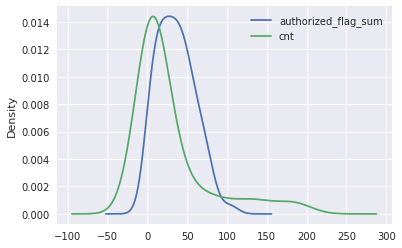

In [185]:
tmp = trans_agg_loy0[col].value_counts().reset_index().rename(columns={'index':col, col:'cnt'})
tmp.plot(kind='kde')

====authorized_flag_sum====


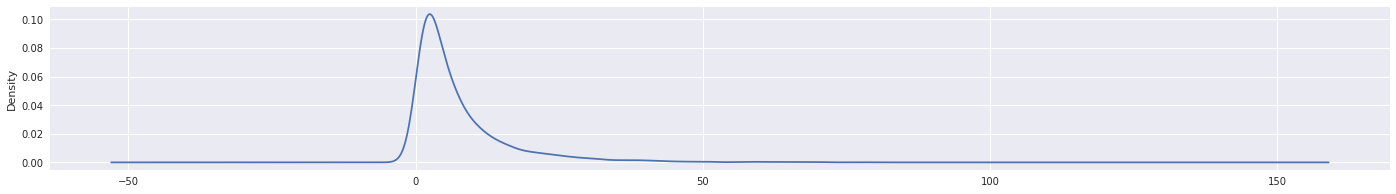

====category_1_sum====


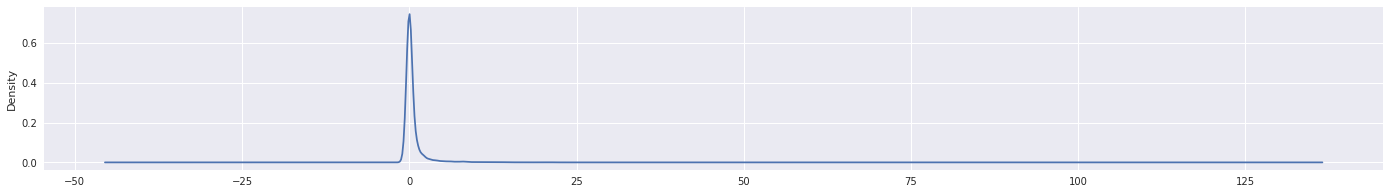

====installments_sum====


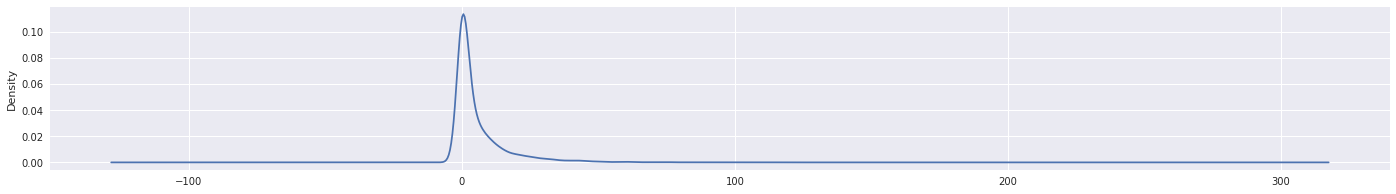

====merchant_category_id_sum====


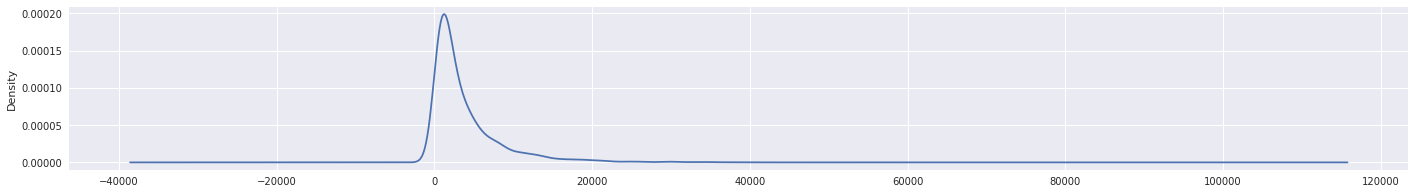

====month_lag_sum====


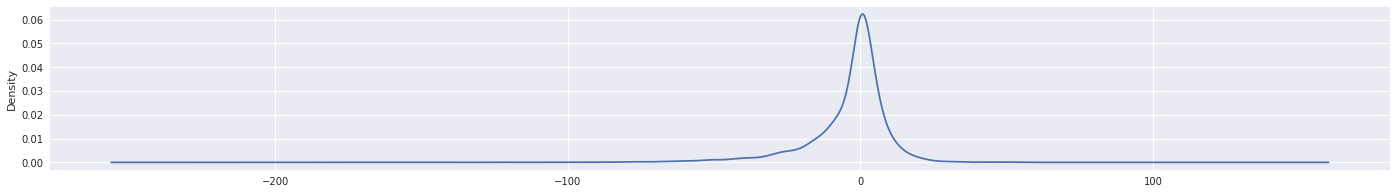

====purchase_amount_sum====


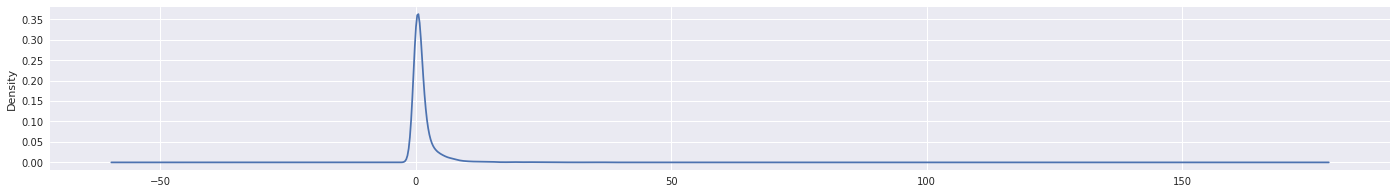

====subsector_id_sum====


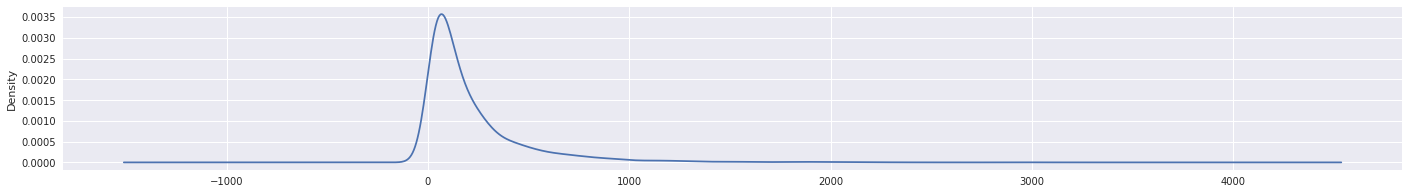

====feature_1_sum====


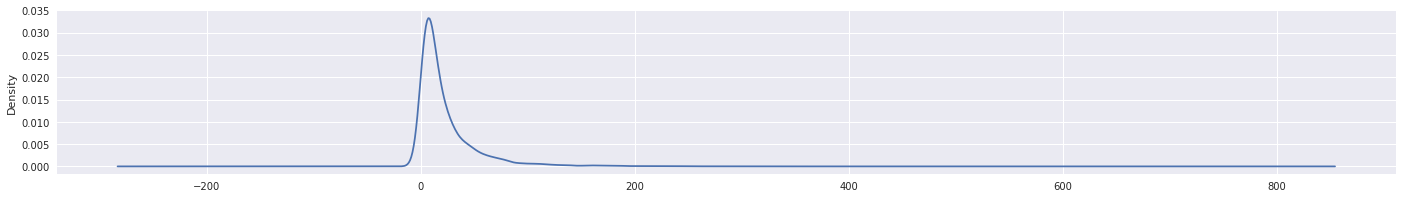

====feature_2_sum====


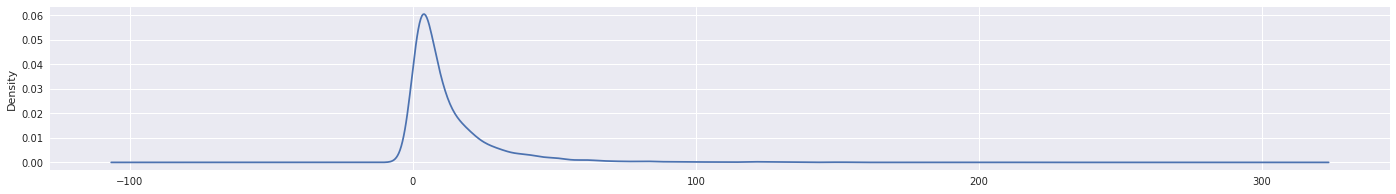

====feature_3_sum====


KeyboardInterrupt: 

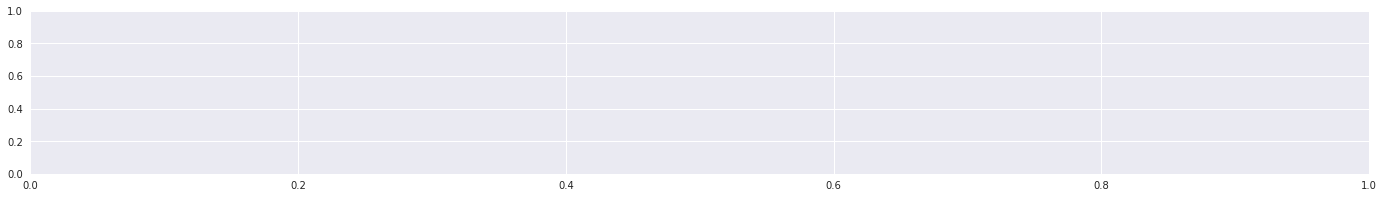

In [206]:
def viz_loy(col):
    if col in ignore_list:return
    if col.count('card_id') :return
    if col.count('city') :return
    if col.count('state') :return
    if col.count('yyyy') :return
    print(f"===={col}====")
    plt.figure(figsize=(24, 3))
    tmp = trans_agg_loy0[col]
#     tmp.plot(kind='kde')
    tmp2 = trans_agg_loy1[col]
    tmp2.plot(kind='kde')
    plt.show()
    
for col in trans_agg_loy0.columns:
    viz_loy(col)

In [155]:
def loy_agg(ids):
    num_list = get_numeric_features(df=df_hist, ignore_list=ignore_list + ['feature_1', 'feature_2', 'feature_3', 'yyyymm', 'month_lag'])
    num_list.remove('merchant_category_id')
    num_list.remove('city_id')
    num_list.remove('state_id')
    num_list.remove('subsector_id')
    num_list.remove('weekofyear')
    num_list.remove('all_term')
    cat_list = get_categorical_features(df=df_hist, ignore_list=[key, 'feature_1', 'feature_2', 'feature_3', 'yyyymm', 'month_lag'])
    cat_list.append('merchant_category_id')
    cat_list.append('state_id')
    
    trans = df_trans.loc[df_trans[key].isin(ids), :]
    trans_sum = trans.groupby([key, 'yyyymm'])[num_list].sum()
    trans_mean = trans.groupby([key, 'yyyymm'])[num_list].mean()
    trans_nuq = trans.groupby([key, 'yyyymm'])[cat_list].nunique()
    trans_sum.columns =  [f"{col}_sum" for col in trans_sum.columns]
    trans_mean.columns =  [f"{col}_mean" for col in trans_mean.columns]
    trans_nuq.columns =  [f"{col}_nuq" for col in trans_nuq.columns]
    trans_agg = pd.concat([trans_sum, trans_mean, trans_nuq], axis=1)
    return trans_agg

p_list = []
for ids in [eda_loy0[key].values, eda_loy1[key].values]:
    p_list.append(loy_agg(ids))
    
df = pd.concat(p_list, axis=0)
df.reset_index(inplace=True)
df.shape

(10012, 14)

In [157]:
df = df[df['yyyymm'].isin(['2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04'])]
p_list = []
for col in df.columns:
    if col in [key, 'yyyymm']:continue
    tmp = df.pivot_table(index=key, columns='yyyymm', values=col)
    tmp.columns = [f"{ym}_{col}" for ym in tmp.columns]
    p_list.append(tmp)

result = pd.concat(p_list, axis=1)
print(result.shape)
result.head()

(1517, 98)


,2017-10_authorized_flag_sum,2017-11_authorized_flag_sum,2017-12_authorized_flag_sum,2018-01_authorized_flag_sum,2018-02_authorized_flag_sum,2018-03_authorized_flag_sum,2018-04_authorized_flag_sum,2017-10_category_1_sum,2017-11_category_1_sum,2017-12_category_1_sum,2018-01_category_1_sum,2018-02_category_1_sum,2018-03_category_1_sum,2018-04_category_1_sum,2017-10_installments_sum,2017-11_installments_sum,2017-12_installments_sum,2018-01_installments_sum,2018-02_installments_sum,2018-03_installments_sum,2018-04_installments_sum,2017-10_purchase_amount_sum,2017-11_purchase_amount_sum,2017-12_purchase_amount_sum,2018-01_purchase_amount_sum,2018-02_purchase_amount_sum,2018-03_purchase_amount_sum,2018-04_purchase_amount_sum,2017-10_authorized_flag_mean,2017-11_authorized_flag_mean,2017-12_authorized_flag_mean,2018-01_authorized_flag_mean,2018-02_authorized_flag_mean,2018-03_authorized_flag_mean,2018-04_authorized_flag_mean,2017-10_category_1_mean,2017-11_category_1_mean,2017-12_category_1_mean,2018-01_category_1_mean,2018-02_category_1_mean,2018-03_category_1_mean,2018-04_category_1_mean,2017-10_installments_mean,2017-11_installments_mean,2017-12_installments_mean,2018-01_installments_mean,2018-02_installments_mean,2018-03_installments_mean,2018-04_installments_mean,2017-10_purchase_amount_mean,2017-11_purchase_amount_mean,2017-12_purchase_amount_mean,2018-01_purchase_amount_mean,2018-02_purchase_amount_mean,2018-03_purchase_amount_mean,2018-04_purchase_amount_mean,2017-10_category_3_nuq,2017-11_category_3_nuq,2017-12_category_3_nuq,2018-01_category_3_nuq,2018-02_category_3_nuq,2018-03_category_3_nuq,2018-04_category_3_nuq,2017-10_merchant_id_nuq,2017-11_merchant_id_nuq,2017-12_merchant_id_nuq,2018-01_merchant_id_nuq,2018-02_merchant_id_nuq,2018-03_merchant_id_nuq,2018-04_merchant_id_nuq,2017-10_yyyymmdd_nuq,2017-11_yyyymmdd_nuq,2017-12_yyyymmdd_nuq,2018-01_yyyymmdd_nuq,2018-02_yyyymmdd_nuq,2018-03_yyyymmdd_nuq,2018-04_yyyymmdd_nuq,2017-10_yyyy_week_nuq,2017-11_yyyy_week_nuq,2017-12_yyyy_week_nuq,2018-01_yyyy_week_nuq,2018-02_yyyy_week_nuq,2018-03_yyyy_week_nuq,2018-04_yyyy_week_nuq,2017-10_merchant_category_id_nuq,2017-11_merchant_category_id_nuq,2017-12_merchant_category_id_nuq,2018-01_merchant_category_id_nuq,2018-02_merchant_category_id_nuq,2018-03_merchant_category_id_nuq,2018-04_merchant_category_id_nuq,2017-10_state_id_nuq,2017-11_state_id_nuq,2017-12_state_id_nuq,2018-01_state_id_nuq,2018-02_state_id_nuq,2018-03_state_id_nuq,2018-04_state_id_nuq
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C_ID_0018bfbe9d,31.0,18.0,12.0,15.0,9.0,4.0,2.0,7.0,9.0,4.0,3.0,2.0,0.0,0.0,42.0,29.0,17.0,21.0,11.0,4.0,2.0,1.286719,2.007456,0.798082,1.244976,0.462746,0.042515,0.025417,0.861111,0.782609,0.750000,0.833333,0.818182,1.0,1.0,0.194444,0.391304,0.250000,0.166667,0.181818,0.0,0.000000,1.166667,1.260870,1.06250,1.166667,1.00000,1.0,1.0,0.035742,0.087281,0.049880,0.069165,0.042068,0.010629,0.012709,2.0,2.0,2.0,2.0,1.0,1.0,1.0,11.0,9.0,8.0,6.0,7.0,4.0,2.0,14.0,11.0,7.0,5.0,5.0,3.0,1.0,4.0,5.0,4.0,3.0,2.0,3.0,1.0,7.0,8.0,6.0,5.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
C_ID_0028e15a78,1.0,1.0,0.0,NaN,2.0,1.0,2.0,8.0,1.0,5.0,NaN,2.0,0.0,1.0,24.0,3.0,15.0,NaN,16.0,1.0,20.0,36.814660,1.957739,29.860434,NaN,0.822797,0.007820,2.841797,0.125000,1.000000,0.000000,NaN,1.000000,1.0,1.0,1.000000,1.000000,1.000000,NaN,1.000000,0.0,0.500000,3.000000,3.000000,3.00000,NaN,8.00000,1.0,10.0,4.601832,1.957739,5.972087,NaN,0.411398,0.007820,1.420898,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,2.0,2.0,1.0,3.0,NaN,1.0,1.0,2.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,2.0,1.0,1.0,1.0,NaN,1.0,1.0,2.0
C_ID_0044a2e2ee,2.0,37.0,35.0,41.0,31.0,7.0,7.0,1.0,10.0,6.0,2.0,2.0,0.0,2.0,0.0,49.0,47.0,53.0,36.0,6.0,7.0,0.501905,26.646602,6.822060,6.762489,4.676815,4.017624,0.524910,1.000000,0.948718,0.945946,1.000000,1.000000,1.0,1.0,0.500000,0.256410,0.162162,0.048780,0.064516,0.0,0.285714,0.000000,1.

In [160]:
result[target] = df_train[target]
result.to_csv('../features/loy_0_1.csv')